# Applying WOfS Bitmasking <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[ls8_fc_albers](https://explorer.sandbox.dea.ga.gov.au/ls8_fc_albers)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product shows water observed for every Landsat-5, Landsat-7 and Landsat-8 image across Australia (excluding External Territories) for the period of 1986 to present.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use this for powerful and flexible image masking.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period
2. Inspect the WOLF bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to different datasets

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages

In [27]:
%matplotlib inline

import datacube
from datacube.storage import masking
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

In [3]:
# Define your area of interest
x = (153.18, 153.38)
y = (-29.35, -29.55)

# Define your period of interest
time = ("2018-01-01", "2018-01-20")

### View the selected location

In [4]:
display_map(x=x, y=y)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [5]:
# Create a reusable query
query = {
    "x": x,
    "y": y,
    "time": time,
    "output_crs": "EPSG:3577",
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofs_fuser,
}

In [6]:
# Load the data from the datacube
wofls = dc.load(product="wofs_albers", **query)

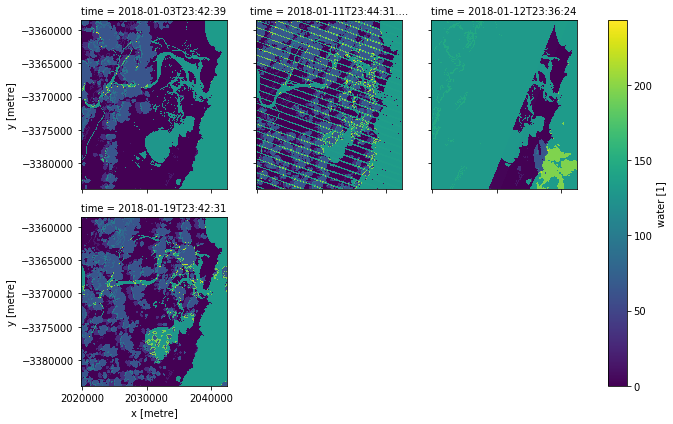

In [7]:
# Plot the loaded WOFLs
wofls.water.plot(col="time", col_wrap=3)
plt.show()

In [8]:
# # Select one image of interest (`time=0` selects the first observation)
# wofl = wofls.isel(time=0)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [9]:
# # Display details of available flags
# flags = masking.describe_variable_flags(wofls)
# flags["bits"] = flags["bits"].astype(str)
# flags.sort_values(by="bits")

In [10]:
# # Show areas flagged as water only (with no other flags set)
# (wofl.water == 128).plot.imshow()
# plt.show()

## Masking 
We can convert the WOFL bit field into a binary array containing True and False values. 
This allows us to use the WOFL data as a mask that can be applied to other datasets.

The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above.


In [11]:
# # Create a mask based on all 'wet' pixels
# wetwofl = masking.make_mask(wofl, wet=True)
# wetwofl.water.plot()
# plt.show()

> **NOTE**: As you can see there is a difference between the above two plots. 
The first (where `water == 128`) is looking at pixels where ONLY the water observation flag was set. For coastal areas the 'sea' bit is also flagged. 
The second image (using `wet=True`), also looks at pixels where the water observation flag was set.

In [12]:
# water = (wofl.water == 128)
# clear = ((wofl.water == 0) | (wofl.water == 128))

In [13]:
# water.plot.imshow()
# plt.show()

In [14]:
# clear

In [15]:
# clear.plot.imshow()
# plt.show()

In [16]:
# water

In [17]:
# wofls

In [18]:
# # Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# fc = dc.load(product="ls8_fc_albers", group_by="solar_day", like=wofls)


In [19]:
# fc

In [20]:
# data_nan = masking.mask_invalid_data(fc)

# # Create water and low-quality fc masks
# # no_water = np.invert( (fc['water'] == 128) | (fc['water'] == 132) )
# # high_ue = (data['UE'] > 30) & no_water

# # Set to null areas with high UE, but no water
# # data_nan = data_nan.where(np.invert(high_ue))

# # # Don't need this anymore
# # data_nan = data_nan.drop("UE")
# # del high_ue

# # Where there's water, set PV to 0
# # data_nan['PV'] = data_nan.PV.where(no_water, 0)
# # data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# # # Where there's water, set BS to 100
# # data_nan['BS'] = data_nan.BS.where(no_water, 100)

# # # don't need this anymore
# # data_nan = data_nan.drop("water")
# # del no_water

# data_month = fc.groupby('time.month').median(dim='time')    


In [21]:
# data_month

In [22]:
# wofls

In [23]:
# import copy
# new_wofls = copy.deepcopy(wofls)
# new_wofls

In [24]:
# # Apply threshold
# new_wofls['water'] = np.where(wofls.values == 128,1,0)
# new_wofls

In [41]:
from itertools import groupby

# Select clear and water pixels
water = (wofls.water == 128).to_dataset()
clear = ((wofls.water == 128) | (wofls.water == 0)).to_dataset()

# Group by month
water_month = water.groupby('time.month').sum(dim='time')   
clear_month = clear.groupby('time.month').sum(dim='time') 

# Calculate frequency of water observations within the month
freq = water_month/clear_month

# Threshold frequency in month to get water or not
water_dominant = freq['water'] > 0.5
water_dominant_nan = water_dominant.where(freq['water'] >= 0)
water_mask = water_dominant_nan

# make values of > 0.5 == 1 (end result in binary water mask)
water_mask_drop = np.where(water_mask > 0.5, 1, water_mask)
water_mask_xr = xr.DataArray(water_mask_drop, coords=water_mask.coords, dims=water_mask.dims)

# Pull tv as numpy array
water_numpy = water_mask_xr.values

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 1

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((water_numpy.shape[1], water_numpy.shape[2]), dtype=np.float32)

# An array with shape (x, y) where values equal count of occurance of water (hopefully consecutive)
count = consecutive_count(tv_numpy, consecutive_numpy, 1)

print('water_numpy',water_numpy.shape)
print()
print('consecutive_numpy',consecutive_numpy.shape)

water_numpy (1, 1013, 906)

consecutive_numpy (1013, 906)


In [42]:
count.shape

(1013, 906)

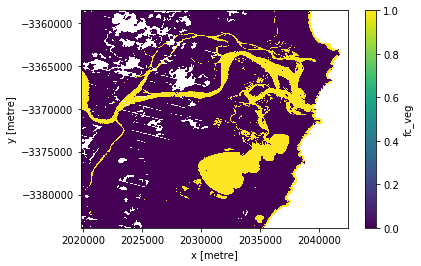

In [47]:
water_reduce = water_mask.max(dim='month')
water_summary = xr.DataArray(consecutive_numpy, coords=water_reduce.coords, dims=water_reduce.dims)  
hello = water_summary.to_dataset(name='fc_veg')
hello.fc_veg.plot()

In [177]:
# clear.isel(time=0).water.plot.imshow()
# plt.show()

In [39]:
# PV_dominant = freq['water'] > 0.5
# PV_dominant_nan = PV_dominant.where(freq['water'] >= 0)
# tv_mask = PV_dominant_nan

# # make values of 2 == 1 (end result in binary veg mask)
# tv_mask_drop = np.where(tv_mask > 0.5, 1, tv_mask)
# tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

# # Pull tv as numpy array
# tv_numpy = tv_mask_xr.values

# # executing consecutive_count function #
# # veg = 2 consecutive months
# required_consecutive = 1

# # Set up array for output (faster to pre-allocate for numba).
# # Needs to be float32 for NaN
# consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# count = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)
# count

In [40]:
# count.shape

In [36]:
# new_water_month = freq.where(freq['water'] > 0.5)
# # new_water_month = (freq['water'] > 0.5)
# new_water_month
# # new_water_month.isel(month=0).water.plot.imshow()
# # plt.show()

In [37]:
# new_water_month

In [38]:
# import xarray as xr
# print('Coords',new_water_month.coords) 
# print()
# print('Dims',new_water_month.dims)

In [150]:
# array = new_water_month.to_array(dim='month')
# array

## Sadness

In [33]:
def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on",
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]
#             print('Counts ',counts)

            # assign values to the empty array
            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [166]:
# class FC_summary(Transformation):
    
#     def consecutive_count(self, tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
#         '''
#         function to get consective count of veg (1) for each pixel across the time series

#         :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
#         :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
#         :param float required_consecutive: how many consectutive 1's to be classified as veg?
#         :param float consec_msk_val: what value to calculcate consectutives on
#                default is veg (1)     
#         '''

#         for y in range(tv_numpy.shape[1]):
#             for x in range(tv_numpy.shape[2]):
#                 # If all the values are nan then just set output to nan and carry on",
#                 pixel = tv_numpy[:,y,x]

#                 if np.all(np.isnan(pixel)):
#                     consecutive_numpy[y,x] = np.nan
#                     continue            

#                 # get counts of consecutive veg classifications
#                 counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

#                 if not counts:
#                     consecutive_numpy[y,x] = 0
#                 elif max(counts) >= required_consecutive:
#                     consecutive_numpy[y,x] = 1
#                 else:
#                     consecutive_numpy[y,x] = 0

#         return consecutive_numpy


#     def compute(self, data):
#         data_nan = masking.mask_invalid_data(data)

#         # Create water and low-quality fc masks
#         no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
#         high_ue = (data['UE'] > 30) & no_water
        
#         # Set to null areas with high UE, but no water
#         data_nan = data_nan.where(np.invert(high_ue))
        
#         # Don't need this anymore
#         data_nan = data_nan.drop("UE")
#         del high_ue

#         # Where there's water, set PV to 0
#         data_nan['PV'] = data_nan.PV.where(no_water, 0)
#         data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

#         # Where there's water, set BS to 100
#         data_nan['BS'] = data_nan.BS.where(no_water, 100)

#         # don't need this anymore
#         data_nan = data_nan.drop("water")
#         del no_water
        
#         #
#         # Group by month, this is a xr.Dataset
#         data_month = data_nan.groupby('time.month').median(dim='time')    

#         # Create mask where PV > BS
#         PV_dominant = data_month['PV'] > data_month['BS']
#         PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

#         # Create mask where NPV > BS
#         NPV_dominant = data_month['NPV'] > data_month['BS']
#         NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

#         # Veg where PV or NPV are greater than BS
#         tv_mask = (PV_dominant_nan + NPV_dominant_nan)

#         # make values of 2 == 1 (end result in binary veg mask)
#         tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
        
#         #
#         # xr.DataArray
#         tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

#         # executing consecutive_count function #
#         # veg = 2 consecutive months
#         required_consecutive = 2

#         # Pull tv as numpy array
#         tv_numpy = tv_mask_xr.values

#         # Set up array for output (faster to pre-allocate for numba).
#         # Needs to be float32 for NaN
#         consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

#         # Run function to get array of with 1 where number of consecutive values for different
#         # dates is >= required_consecutive
#         consecutive_numpy = self.consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

#         # reduce original array to 2D
#         # using max here but not important as we just want to use shape/attributes
#         tv_reduce = tv_mask.max(dim='month')

#         # create new data array with sampe dimensions as original
#         tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)  
#         return tv_summary.to_dataset(name='fc_veg')

#     def measurements(self, input_measurements):
#         return {'fc_veg': Measurement(name='fc_veg', dtype='float32', nodata=float('nan'), units='1')}

NameError: name 'Transformation' is not defined